In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux, get_Max_Phase_Speed
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans
import morph_geom_lib as mgl

from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

# TVD-WENO Scheme

https://www.ams.org/journals/mcom/1998-67-221/S0025-5718-98-00913-2/S0025-5718-98-00913-2.pdf

The TVD second order Runge-Kutta method we consider is the one given in
[12]:
$$u^{(1)} = u^n + ∆tL(u^n)$$,
$$u^{n+1} = 0.5u^n + 0.5u^{(1)} + 1/2∆tL(u^{(1)})$$


Z: 87
0.01569138276553106


Text(0, 0.5, 'z (m)')

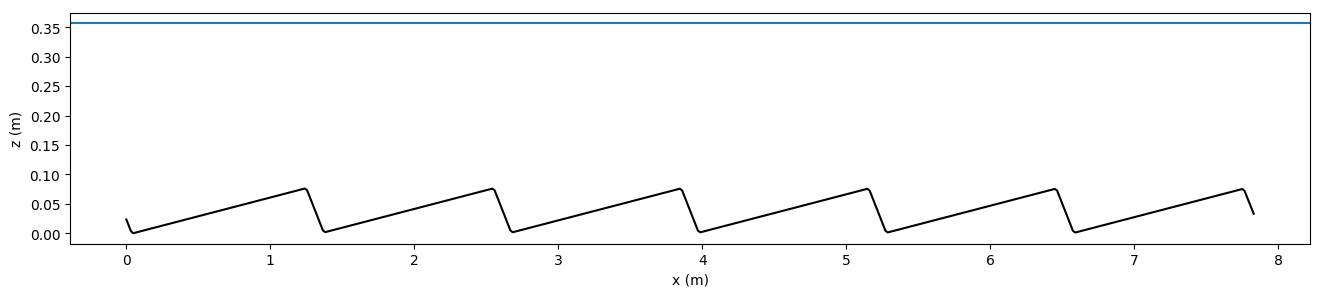

In [2]:
profile_folder = '/pymorph/notebooks/Paper_3/flume_profile_smoothed_v002.txt'
xc, z0 = mgl.readQueensFlume(profile_folder,1)

fig = plt.figure(figsize=(16, 3))
#plt.plot(xc,z0,'b')

dunes = 6

xsaw = np.linspace(0, 1,500)
simTime = 60*10 # Runtime in seconds
dt = 0.5 # Time step size (s)

zsaw = 0.076*(signal.sawtooth(2*dunes*np.pi * xsaw) + 1.)/2
xsaw = xsaw*xc.max()*dunes*0.5
#plt.plot(xsaw,zsaw)


dx = xsaw[1]-xsaw[0]
znew, iterations1 = avalanche_model(dx,xsaw, zsaw, adjustment_angle=28.)
# Now flip it to run in reverse
zflip = np.flip(znew, axis=0)
zflip, iterations1 = avalanche_model(dx,xsaw, zflip, adjustment_angle=28.)
znew = np.flip(zflip, axis=0)

znew = (znew - np.min(znew))/np.ptp(znew)
znew = znew*0.076

plt.plot(xsaw,znew,'-',color='k')
plt.axhline(0.357)
print(dx)
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [9]:
#--------------------------------
# Set up the geometry
#--------------------------------
xc = xsaw.copy()
zc = znew.copy()
x0 = xsaw.copy()
z0 = znew.copy()
nx = len(xc)

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

# The ubar for this is 0.561 m/s

hout = 0.357
Qin = q32cm

#--------------------------------
# Set up the Domain Conditions
#--------------------------------
Mannings = 0.048
Slope = 1.26/1000.
# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 2650
nP = 0.4
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 30.*60       # Runtime in seconds
dt = 15                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionInterval = 60.*1


#--------------------------------
# Initalize the model
#--------------------------------
sws = shallow_water_solver(kernel_language='Fortran')
sws.set_solver(max_steps=100000)
sws.set_state_domain(xc,zc)
sws.set_mannings_source_term(mannings=Mannings, slope=Slope)
sws.set_Dirichlet_BC(hout,Qin)
sws.set_inital_conditions(hout, 0.0)
sws.set_controller(tfinal=300., num_output_times=3)
sws.run()
cntrl = sws.get_controller()

#--------------------------------
# Initalize the model
#--------------------------------
h = sws.get_hf()
u = sws.get_uf()
q = sws.get_qf()

roe_speed = np.zeros(nx)
flux = np.zeros(nx)
qbedload = np.zeros(nx)
verts = []
tsteps = []
iterations = 0
cntr = 0

time_series = collections.OrderedDict()
time = 0

#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy()
    z1 = zc.copy()
    
    # ---------------------------------------'
    # Step 1 ''
    # ----------------------------------------'
    for i in range(0,nx): #i=2
        zloc = get_stencil(zn,i-2,i+4)        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)!=6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        z1[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
        
    
    sws = shallow_water_solver(kernel_language='Fortran')
    sws.set_solver(max_steps=100000)
    sws.set_state_domain(xc,z1)
    sws.set_mannings_source_term(mannings=Mannings, slope=Slope)
    sws.set_conditions_from_previous(h, q)
    sws.set_Dirichlet_BC(hout,Qin)
    sws.set_controller(tfinal=10., num_output_times=1)
    sws.run()
    cntrl = sws.get_controller()      

    h = sws.get_hf()
    u = sws.get_uf()
    q = sws.get_qf()
    surf = h + z1
    
    # ---------------------------------------'
    # Step 2
    # ----------------------------------------'
    
    for i in range(0,nx): #i=2
        zloc = get_stencil(z1, i-2, i+4)        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload, i-2,i+4)
        if len(qloc)!=6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        zc[i] = 0.5*z1[i] + 0.5*zn[i] - (1./(1.-nP))*dt/dx*(floc[1]-floc[0])
    
    sws = shallow_water_solver(kernel_language='Fortran')
    sws.set_solver(max_steps=100000)
    sws.set_state_domain(xc,zc)
    sws.set_mannings_source_term(mannings=Mannings, slope=Slope)
    sws.set_conditions_from_previous(h, q)
    sws.set_Dirichlet_BC(hout,Qin)
    sws.set_controller(tfinal=5., num_output_times=1)
    sws.run()
    cntrl = sws.get_controller()      

    h = sws.get_hf()
    u = sws.get_uf()
    q = sws.get_qf()
    surf = h + z1
    
    
    # Apply the avalanche model
    zc, iterations1 = avalanche_model(dx,xc, zc, adjustment_angle=28.)
    # Now flip it to run in reverse
    zflip = np.flip(zc, axis=0)
    zflip, iterations1 = avalanche_model(dx,xc, zflip, adjustment_angle=28.)
    zc = np.flip(zflip, axis=0)
    
            
   

    iterations = 0
        
    slope = np.gradient(zc,dx)
    
    if 1==0:
        # ----------------------------------
        # Apply the two-step smooting scheme Eq. 6 in Niemann et al 2011.
        # ----------------------------------
        zhat = np.zeros(nx)
        for i in range(0, nx):  # i=2
            zlocal = get_stencil(zc, i - 1, i + 2)
            zhat[i] = 0.5*zlocal[1] + 0.25*(zlocal[0]+zlocal[2])

        for i in range(0, nx):
            zhatlocal = get_stencil(zhat, i - 1, i + 2)
            zc[i] = (3./2.)*zhatlocal[1] - 0.25*(zhatlocal[0]+zhatlocal[2])


    ## Nov 13 2018 - Can modify later
    for i in range(0,nx): #i=2        
        #zlocal = get_stencil(zc,i-2,i+2)
        #qbedload[i] = sedtrans.get_unit_bed_load2(h[i],u[i],D50,rho_particule,type='bagnold')
        qbedload[i] = sedtrans.get_unit_bed_load_slope(h[i],u[i],D50,slope[i], 
                                                       rho_particule, 
                                                       angleReposeDegrees = 30.0, 
                                                       type='bagnold',
                                                        useSlopeAdjust=False)
    
    #time_series[time] = zc
    #time+=1
    
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt/60.)        
        np.save('flume_dunes', verts)
        Courant = get_Max_Phase_Speed(qbedload,zc,nP)*dt/dx
        print('Time step: {0} mins - uavg: {1} - Elevation {2}'.format(n*dt/60., u.mean(), surf.mean()))
        print('Courant number: {0}'.format(Courant))
        
print('Done')

2019-05-11 16:29:05,689 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-11 16:29:14,138 INFO CLAW: Solution 1 computed for time t=100.000000
2019-05-11 16:29:32,133 INFO CLAW: Solution 2 computed for time t=200.000000
2019-05-11 16:29:37,585 INFO CLAW: Solution 3 computed for time t=300.000000
2019-05-11 16:29:37,617 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-11 16:29:38,191 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-11 16:29:38,234 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-11 16:29:38,522 INFO CLAW: Solution 1 computed for time t=5.000000
2019-05-11 16:29:38,845 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-11 16:29:39,759 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-11 16:29:39,804 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-11 16:29:40,575 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-11 16:29:40,617 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-11 16:29

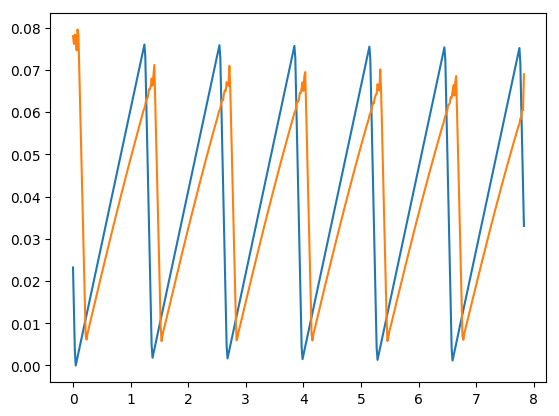

In [8]:
plt.plot(x0,z0)
plt.plot(xc,zc)